# Introduction

So far, we've jointly optimized purity and completeness using a recent SAGA II+ catalog (2021-02-11). However, we haven't optimized a CNN *as a function of target density*. Moreover, we haven't been able to optimize the models so that the resultant redshift distributions look like [Yao's plots](https://hackmd.io/@yymao/SJ8v0KhZO).

Here we will do a few new things:
- use the 2021-02-19 data set (updated with new redshifts and a few

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tqdm.notebook as tqdm

seed = 256

%matplotlib inline

In [2]:
import sys
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from utils import *

learner_metrics = [accuracy, F1Score(), Recall(), Precision()]

sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *

In [3]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['lower_z'] = df.SPEC_Z < 0.02
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

## Util functions from last time

In [4]:

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(224)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)
seed = 256


def oversample(df: pd.DataFrame, num_oversample=None, label_column='lower_z'):
    """Oversample a `pd.DataFrame` such that `label_column` classes
    are balanced. Note that the result is not shuffled.
    """
    lst = [df]
    N_majority = (~df[label_column]).sum()
    N_minority = ( df[label_column]).sum()
    
    try:
        # -1 -> rebalance casses, other negative numbers will raise a ValueError
        if num_oversample == -1: num_oversample = N_majority - N_minority
        lst.append(df[df[label_column]].sample(num_oversample, replace=True))
    except ValueError:
        print('Make sure that `num_oversample` is larger than the number of objects in the label class')

    return pd.concat(lst)

def get_saga_dls(
    saga, 
    label_column='lower_z',
    split_column=None,
    oversample=None, 
    undersample=None, 
    valid_pct=0.25, 
    bs=64, 
    PATH=PATH,
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=256,
):
    """Returns Dataloaders `dls` based on an input catalog `saga`. 
    If `undersample` is an integer, then it will sample fewer from the 
    nonsatellites class. If `oversample` is an integer, then it will sample
    that many satellites. User can also provide fraction of sample 
    for validation by supplying `valid_pct`.
    """
    
    
    is_low_z = (saga.SPEC_FLAG == 1) & (saga[label_column] == 1) # 1 == True

    if undersample is None:
        df = saga.copy()
    elif isinstance(undersample, int):
        df = pd.concat(
            (saga[~is_low_z].sample(undersample), saga[is_low_z]),
        )
    else:
        raise TypeError('Please enter an integer for `undersample`')
    
    if split_column is None:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    elif split_column in df.columns:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=ColSplitter(split_column),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    else:
        raise TypeError('Please enter a valid column for splitting train/valid subsets')
    
    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    if oversample is not None:
        return resample_dls(
            dls, label_column=label_column, split_column=split_column, num_oversample=oversample,
            bs=bs, PATH=PATH, item_tfms=item_tfms, batch_tfms=batch_tfms, seed=seed
        )
    else:
        return dls
    

def resample_dls(
    dls, 
    label_column='HAS_SAT_Z', 
    num_oversample=None,
    split_column=None,
    bs=64, PATH=PATH, 
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=seed,
):
    """Given Dataloaders `dls` -- you may need to run `get_saga_dls()` first --
    oversample the satellites (generally outnumbered 100:1) in order to
    balance the classes. The classes are split by a binary `label_column`,
    which defaults to 'HAS_SAT_Z'. 
    
    Note that this method is probably not memory efficient.
    """
    train = dls.train.items.copy()
    valid = dls.valid.items.copy()

    train_oversampled = oversample(train, num_oversample=num_oversample, label_column=label_column)

    if split_column is None:
        split_column = 'is_valid'
        train_oversampled[split_column] = False
        valid[split_column] = True
        
    df_oversampled = pd.concat((train_oversampled, valid)).sample(frac=1)
    
    # create resampled datablock
    dblock_oversampled = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader(label_column),
        splitter=ColSplitter(split_column),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    return ImageDataLoaders.from_dblock(dblock_oversampled, df_oversampled, path=PATH, bs=bs)

In [5]:
def get_top_N_metrics(subset, N):
    
    evaluation_metrics = {}
    
    # z<0.02
    TP = ((subset.index < N) & (subset.SPEC_Z < 0.02)).sum()
    TN = ((subset.index > N) & (subset.SPEC_Z > 0.02)).sum()
    FP = ((subset.index < N) & (subset.SPEC_Z > 0.02)).sum()
    FN = ((subset.index > N) & (subset.SPEC_Z < 0.02)).sum()
    
    evaluation_metrics['completeness_02'] = TP / (TP + FN)

    # z<0.03
    TP = ((subset.index < N) & (subset.SPEC_Z < 0.03)).sum()
    TN = ((subset.index > N) & (subset.SPEC_Z > 0.03)).sum()
    FP = ((subset.index < N) & (subset.SPEC_Z > 0.03)).sum()
    FN = ((subset.index > N) & (subset.SPEC_Z < 0.03)).sum()
#     metrics['completeness_03'] = TP / (TP + FN)
    evaluation_metrics['purity_03'] = TP / (TP + FP)
    
    evaluation_metrics['geometric_mean'] = np.sqrt(evaluation_metrics['completeness_02'] * evaluation_metrics['purity_03'])
    evaluation_metrics['harmonic_mean'] = 2 / (1/evaluation_metrics['completeness_02'] + 1/evaluation_metrics['purity_03'])
    
    return evaluation_metrics


# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss


# A simple model to minimize median redshift

In [6]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['lower_z'] = df.SPEC_Z < 0.02
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [7]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 1024  

In [49]:
# regress on redshift
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('SPEC_Z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [50]:
dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

(no oversampling yet)

## Optimize with MAE (L1) loss 

In [51]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

In [52]:
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=L1LossFlat(),
)

# learn.lr_find()

In [53]:
learn.fit_one_cycle(10, 0.003)

In [64]:
# learn.save('hybridcnn-simple_L1')
learn.load('hybridcnn-simple_L1')

## Check metrics

In [65]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_z'] = preds.flatten()

/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, 'Predicting $z$ (L1 Loss)')

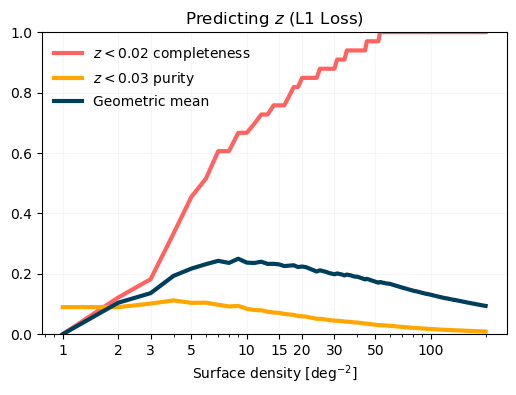

In [56]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_z', ascending=True).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L1 Loss)')

Text(0.5, 1.0, 'Predicting $z$ (L1 Loss)')

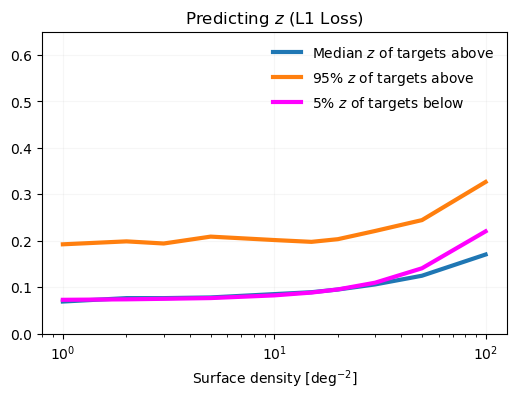

In [66]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_z', ascending=True)[:N]
    complement = res[mag_range].sort_values('pred_z', ascending=True)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')


plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L1 Loss)')

## MSE

In [58]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=MSELossFlat(),
)

learn.fit_one_cycle(10, 1e-2)

In [59]:
# learn.save('hybridcnn-simple_L2')

In [60]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_z'] = preds.flatten()

Text(0.5, 1.0, 'Predicting $z$ (L2 Loss)')

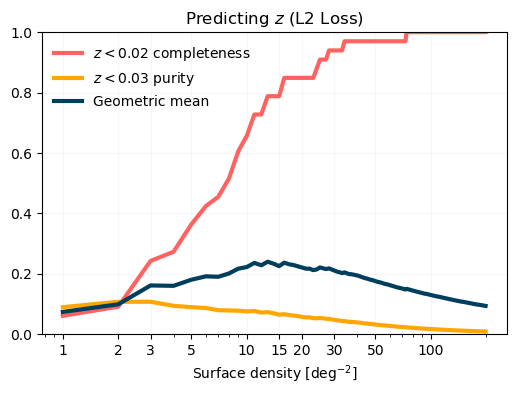

In [61]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_z', ascending=True).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L2 Loss)')

Text(0.5, 1.0, 'Predicting $z$ (L2 Loss)')

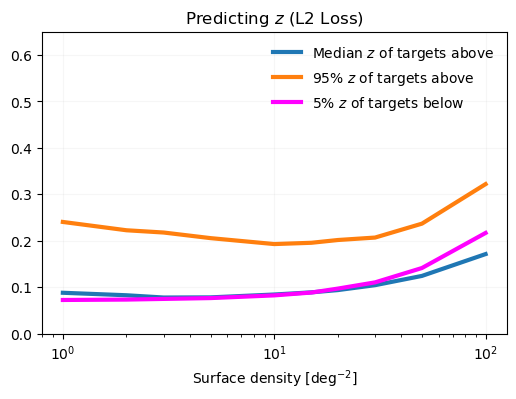

In [63]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_z', ascending=True)[:N]
    complement = res[mag_range].sort_values('pred_z', ascending=True)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L2 Loss)')

# Optimize classification with focal loss

In [30]:
# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss

In [68]:
# classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [69]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=FocalLossFlat(),
)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.9120108485221863)

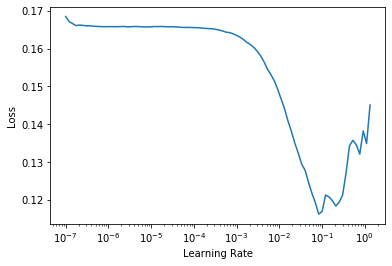

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(10, 1e-2)

In [26]:
# learn.save('hybridcnn-simple_focal')
learn.load('hybridcnn-simple_focal');

In [27]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_low_z'] = preds.softmax(1)[:,1].numpy()

Text(0.5, 1.0, 'Classifying $z < 0.03$ (Focal Loss)')

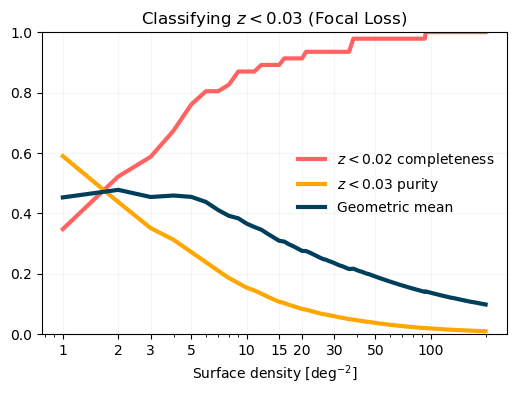

In [28]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (Focal Loss)')

Text(0.5, 1.0, 'Classifying $z < 0.03$ (Focal Loss)')

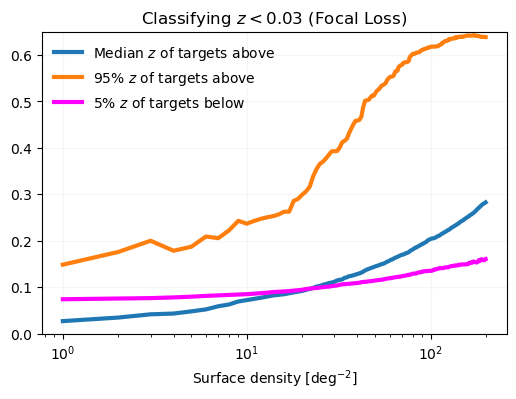

In [29]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (Focal Loss)')

# Label-smoothing cross entropy

In [73]:
# classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [75]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=LabelSmoothingCrossEntropy(eps=0.1),
)

learn.fit_one_cycle(10, 1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


In [76]:
# learn.save('hybridcnn-simple_ce-ls')
learn.load('hybridcnn-simple_ce-ls');

In [77]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_low_z'] = preds.softmax(1)[:,1].numpy()

Text(0.5, 1.0, 'Classifying $z < 0.03$ (LS Cross Entropy)')

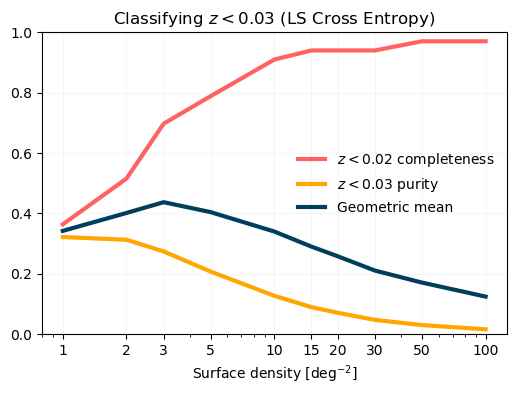

In [82]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(metrics_df.index, metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(metrics_df.index, metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(metrics_df.index, metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (LS Cross Entropy)')

Text(0.5, 1.0, 'Classifying $z < 0.03$ (LS Cross Entropy)')

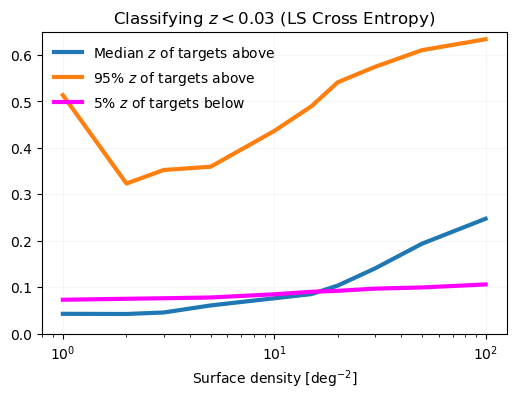

In [81]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (LS Cross Entropy)')

# Use focal loss and optimize different redshifts


In [6]:
# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss

In [8]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 1024  

## z < 0.1

In [10]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['z_0p1'] = df.SPEC_Z < 0.1

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [11]:
# classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('z_0p1'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [12]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=FocalLossFlat(),
)

In [13]:
learn.fit_one_cycle(10, 1e-2)

In [14]:
learn.save('hybridcnn-simple_focal_z<0.1')
learn.load('hybridcnn-simple_focal_z<0.1');

Get predictions

In [15]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_low_z'] = preds.softmax(1)[:,1].numpy()

Text(0.5, 1.0, 'Classifying $z < 0.1$ (Focal Loss)')

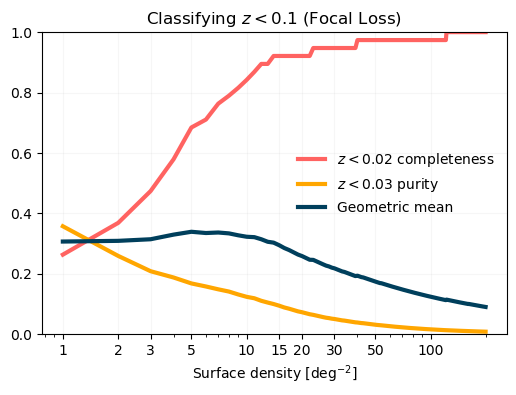

In [16]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.1$ (Focal Loss)')

Text(0.5, 1.0, 'Classifying $z < 0.1$ (Focal Loss)')

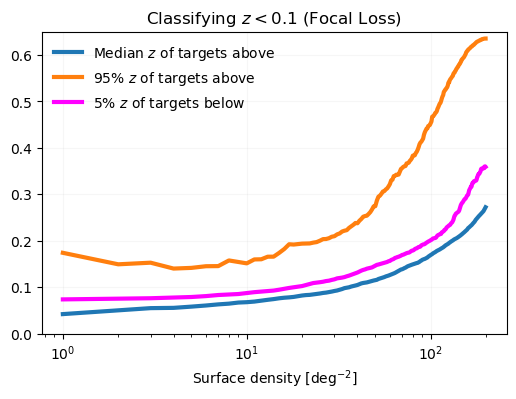

In [17]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.1$ (Focal Loss)')

## Classify z < 0.05

In [18]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['z_0p05'] = df.SPEC_Z < 0.05

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [19]:
# classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('z_0p05'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [20]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=FocalLossFlat(),
)

In [21]:
learn.fit_one_cycle(10, 1e-2)

In [22]:
learn.save('hybridcnn-simple_focal_z<0.05')
learn.load('hybridcnn-simple_focal_z<0.05');

Get predictions

In [23]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_low_z'] = preds.softmax(1)[:,1].numpy()

Text(0.5, 1.0, 'Classifying $z < 0.05$ (Focal Loss)')

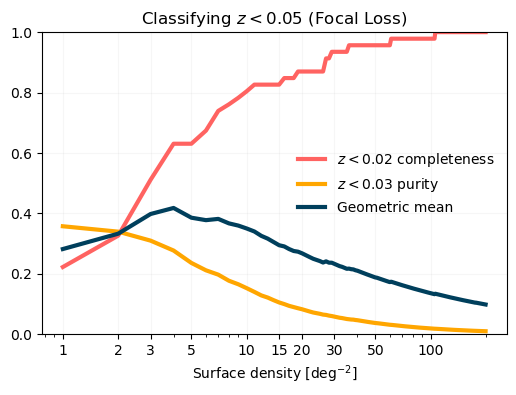

In [24]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.05$ (Focal Loss)')

Text(0.5, 1.0, 'Classifying $z < 0.05$ (Focal Loss)')

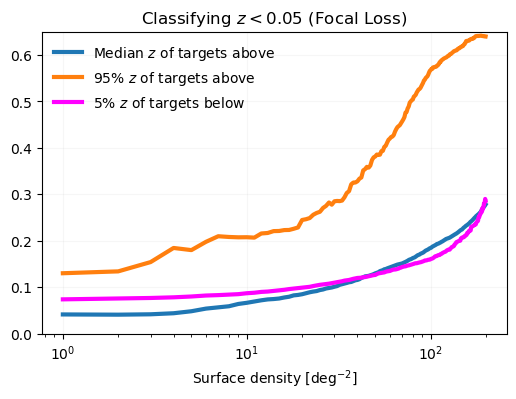

In [25]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.05$ (Focal Loss)')

# Full tests with Focal Loss (no oversampling)

In [20]:
results = {}

## Size 80 pixels, hd-xresnet18

In [12]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [18]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [19]:
label_column = 'low_z'
loss_func = FocalLossFlat()

In [21]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dls = get_saga_dls(
        df, 
        label_column=label_column, 
        split_column='kfold_split',
        oversample=None,
        PATH=PATH,
        seed=seed,
        bs=bs,
        item_tfms=item_tfms
    )
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(5, 1e-2)
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[27269   109]
 [  250   376]]
  Beginning fold 2/4


[[27289    91]
 [  282   342]]
  Beginning fold 3/4


[[27229   133]
 [  217   425]]
  Beginning fold 4/4


[[27244   103]
 [  276   381]]


In [24]:
# learn.save('hdxresnet18_focal_sz80')
# learn.load('hdxresnet18_focal_sz80');

In [23]:
results['hdxresnet18_focal_sz80'] = pd.concat(df_folds)
results['hdxresnet18_focal_sz80'].to_csv(f'{PATH}/results/desi-sv/hdxresnet18_focal_sz80.csv', index=False)

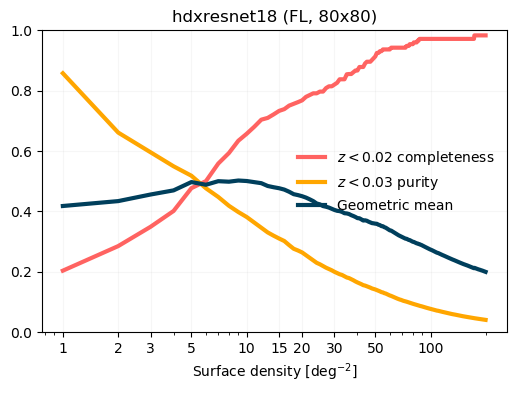

In [25]:
metrics_dict = {}

res = results['hdxresnet18_focal_sz80']

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet18 (FL, 80x80)');

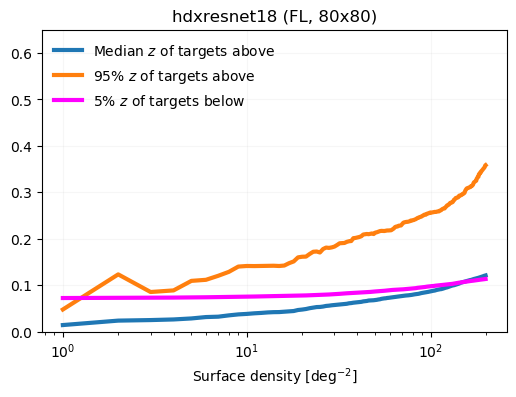

In [26]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 80x80)');

## size 80 pixels, hdxresnet34

In [55]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [56]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 1024  

In [57]:
label_column = 'low_z'
loss_func = FocalLossFlat()

In [58]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dls = get_saga_dls(
        df, 
        label_column=label_column, 
        split_column='kfold_split',
        oversample=None,
        PATH=PATH,
        seed=seed,
        bs=bs,
        item_tfms=item_tfms
    )
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(5, 1e-2)
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[27251    94]
 [  272   387]]
  Beginning fold 2/4


[[27246   108]
 [  268   382]]
  Beginning fold 3/4


[[27255   128]
 [  270   351]]
  Beginning fold 4/4


[[27263   122]
 [  233   386]]


In [59]:
# learn.save('hdxresnet34_focal_sz80')
# learn.load('hdxresnet34_focal_sz80');

In [60]:
results['hdxresnet34_focal_sz80'] = pd.concat(df_folds)
results['hdxresnet34_focal_sz80'].to_csv(f'{PATH}/results/desi-sv/hdxresnet34_focal_sz80.csv', index=False)

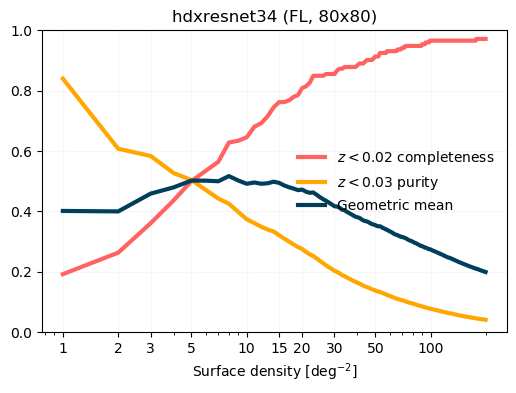

In [68]:
metrics_dict = {}

res = results['hdxresnet34_focal_sz80']

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet34 (FL, 80x80)');

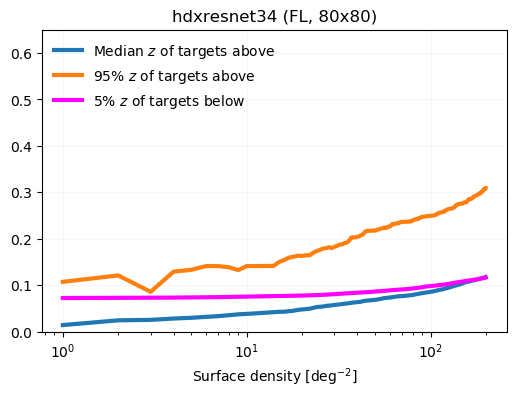

In [69]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet34 (FL, 80x80)');

## 224x224, hdxresnet18

In [70]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [71]:
sz = 224
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [72]:
label_column = 'low_z'
loss_func = FocalLossFlat()

In [73]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dls = get_saga_dls(
        df, 
        label_column=label_column, 
        split_column='kfold_split',
        oversample=None,
        PATH=PATH,
        seed=seed,
        bs=bs,
        item_tfms=item_tfms
    )
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(5, 1e-2)
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[27249   113]
 [  266   376]]
  Beginning fold 2/4


[[27265   113]
 [  279   347]]
  Beginning fold 3/4


[[27266   101]
 [  276   361]]
  Beginning fold 4/4


[[27236   124]
 [  284   360]]


In [74]:
# learn.save('hdxresnet18_focal_sz224')
# learn.load('hdxresnet18_focal_sz224');

In [75]:
results['hdxresnet18_focal_sz224'] = pd.concat(df_folds)
results['hdxresnet18_focal_sz224'].to_csv(f'{PATH}/results/desi-sv/hdxresnet18_focal_sz224.csv', index=False)

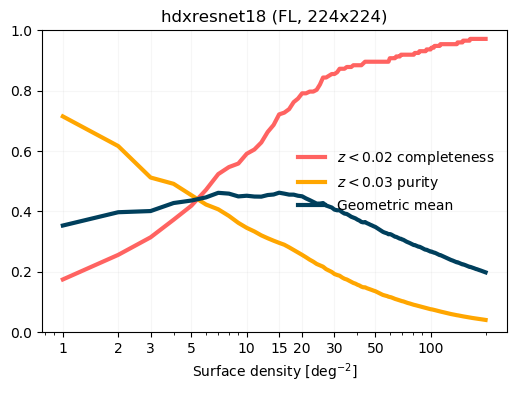

In [87]:
metrics_dict = {}

res = results['hdxresnet18_focal_sz224']

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet18 (FL, 224x224)');

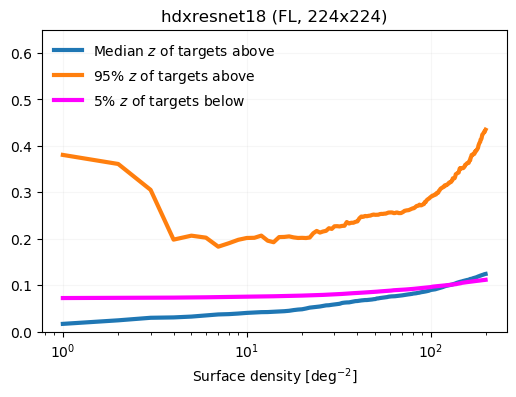

In [88]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 224x224)');

# Focal Loss hyperparameter tweaks

In the original paper (Lin et al. 2018) it was stated that $\alpha = [0.25, 0.75]$ gave best results. This is equivalent to weight ratios of 1.25 - 4...

## ~~alpha=0.25, Size 80 pixels, hd-xresnet18~~

This gives something like 30% purity, 95% completeness.

In [8]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [9]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [14]:
label_column = 'low_z'

# focal loss weight params
alpha = 0.25
weight = tensor([alpha, 1-alpha]).cuda()
loss_func = FocalLossFlat(weight=weight)

In [15]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dls = get_saga_dls(
        df, 
        label_column=label_column, 
        split_column='kfold_split',
        oversample=None,
        PATH=PATH,
        seed=seed,
        bs=bs,
        item_tfms=item_tfms
    )
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(5, 1e-2)
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[26242  1156]
 [   57   549]]
  Beginning fold 2/4


KeyboardInterrupt: 

In [ ]:
# learn.save('hdxresnet18_focal_sz80_alpha0p25')
# learn.load('hdxresnet18_focal_sz80_alpha0p25');

In [ ]:
results['hdxresnet18_focal_sz80_alpha0p25'] = pd.concat(df_folds)
results['hdxresnet18_focal_sz80_alpha0p25'].to_csv(f'{PATH}/results/desi-sv/hdxresnet18_focal_sz80_alpha0p25.csv', index=False)

In [ ]:
metrics_dict = {}

res = results['hdxresnet18_focal_sz80_alpha0p25']

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet18 (FL, 80x80, alpha=0.25)');

In [ ]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 80x80, alpha=0.25)');

In [22]:
results = {}

## size 80, gamma=5

In [16]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [17]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [18]:
label_column = 'low_z'

# focal loss weight params
gamma = 5
loss_func = FocalLossFlat(gamma=gamma)

In [19]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dls = get_saga_dls(
        df, 
        label_column=label_column, 
        split_column='kfold_split',
        oversample=None,
        PATH=PATH,
        seed=seed,
        bs=bs,
        item_tfms=item_tfms
    )
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(5, 1e-2)
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[27244   140]
 [  286   334]]
  Beginning fold 2/4


[[27237    94]
 [  322   351]]
  Beginning fold 3/4


[[27236   133]
 [  270   365]]
  Beginning fold 4/4


[[27261   122]
 [  268   353]]


In [20]:
# learn.save('hdxresnet18_focal_sz80_gamma5')
# learn.load('hdxresnet18_focal_sz80_gamma5');

In [23]:
results['hdxresnet18_focal_sz80_gamma5'] = pd.concat(df_folds)
results['hdxresnet18_focal_sz80_gamma5'].to_csv(f'{PATH}/results/desi-sv/hdxresnet18_focal_sz80_gamma5.csv', index=False)

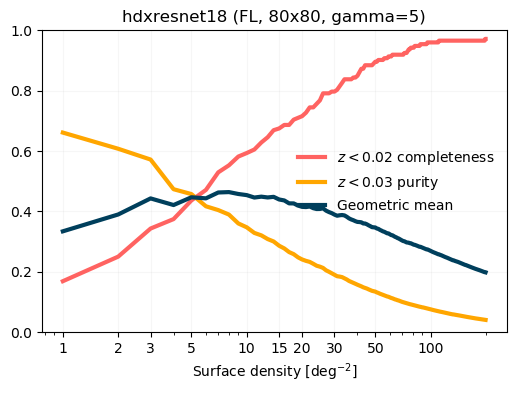

In [24]:
metrics_dict = {}

res = results['hdxresnet18_focal_sz80_gamma5']

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet18 (FL, 80x80, gamma=5)');

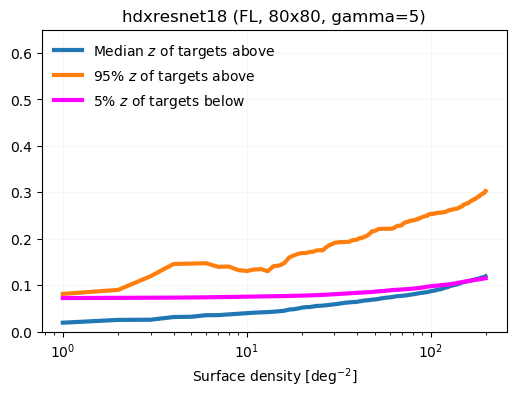

In [25]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 80x80, gamma=5)');

## size 80, gamma=1

In [26]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [27]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [28]:
label_column = 'low_z'

# focal loss weight params
gamma = 1
loss_func = FocalLossFlat(gamma=gamma)

In [29]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(5, 1e-2)
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[27209   153]
 [  229   413]]
  Beginning fold 2/4


[[27213   128]
 [  260   403]]
  Beginning fold 3/4


[[27255    98]
 [  279   372]]
  Beginning fold 4/4


[[27308   103]
 [  246   347]]


In [30]:
# learn.save('hdxresnet18_focal_sz80_gamma1')
# learn.load('hdxresnet18_focal_sz80_gamma1');

In [31]:
results['hdxresnet18_focal_sz80_gamma1'] = pd.concat(df_folds)
results['hdxresnet18_focal_sz80_gamma1'].to_csv(f'{PATH}/results/desi-sv/hdxresnet18_focal_sz80_gamma1.csv', index=False)

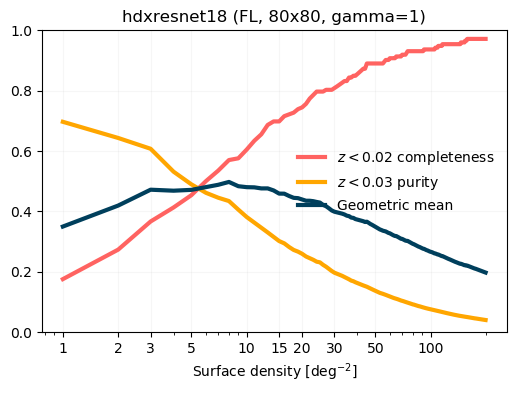

In [33]:
metrics_dict = {}

res = results['hdxresnet18_focal_sz80_gamma1']

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet18 (FL, 80x80, gamma=1)');

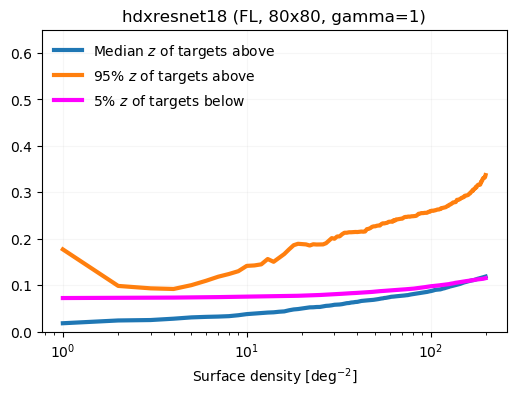

In [34]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 80x80, gamma=1)');

# Training final models

## `hdxresnet18-sz80`

In [27]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [28]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [29]:
label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

In [30]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(10, 1e-2)
    
    torch.save(learn.model.state_dict(), f'{PATH}/models/desi-sv_FL-hdxresnet18-sz{sz}_{k}');
    
    p_low_z, true_low_z = learn.get_preds()

    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z[:, 1]
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, valid.pred_low_z  > 0.5))

  Beginning fold 1/4


[[27232   118]
 [  253   401]]
  Beginning fold 2/4


[[27276   108]
 [  254   366]]
  Beginning fold 3/4


[[27261   102]
 [  223   418]]
  Beginning fold 4/4


[[27249   121]
 [  228   406]]


In [31]:
pd.concat(df_folds).to_csv(f'{PATH}/results/desi-sv/FL-hdxresnet18-sz{sz}.csv', index=False)
res = pd.read_csv(f'{PATH}/results/desi-sv/FL-hdxresnet18-sz{sz}.csv')

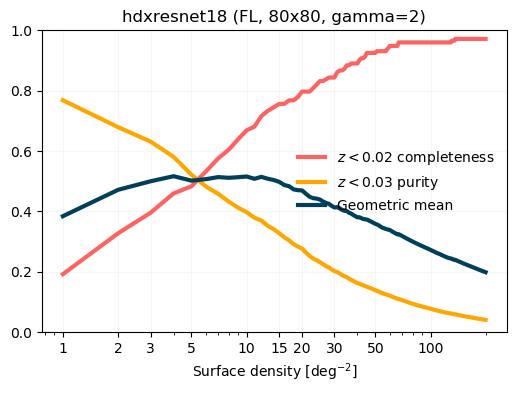

In [35]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet18 (FL, 80x80, gamma=2)');

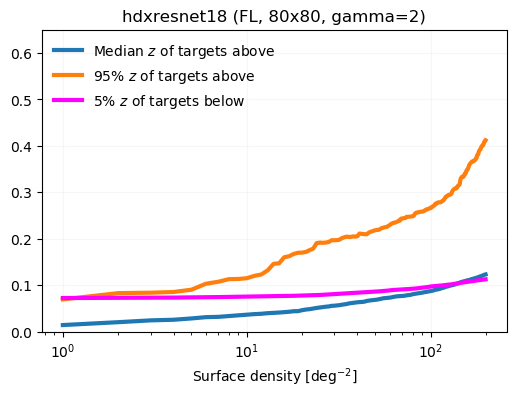

In [36]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 80x80, gamma=2)');

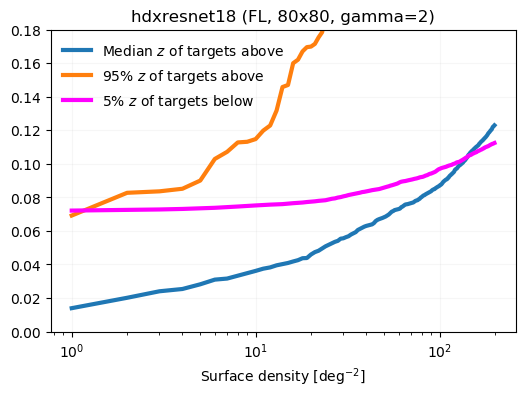

In [40]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.18)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet18 (FL, 80x80, gamma=2)');

## ~~`hdxresnet18-sz144`~~

In [34]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [41]:
sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [42]:
label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

In [43]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(10, 1e-2)
    
    torch.save(learn.model.state_dict(), f'{PATH}/models/desi-sv_FL-hdxresnet18-sz{sz}_{k}');
    
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


[[27210   139]
 [  229   426]]
  Beginning fold 2/4


[[27284   126]
 [  247   347]]
  Beginning fold 3/4


[[27253   107]
 [  226   418]]
  Beginning fold 4/4


[[27237   111]
 [  253   403]]


## `hdxresnet34-sz144`

In [6]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [7]:
sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [8]:
label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

In [15]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
        
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True

    df['kfold_split'] = val_mask

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader('low_z'),
        splitter=ColSplitter('kfold_split'),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

    model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=loss_func,
        metrics=learner_metrics,
    )

    learn.fit_one_cycle(10, 1e-2)

    torch.save(learn.model.state_dict(), f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}_{k}');

    p_low_z, true_low_z = learn.get_preds()

    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z[:, 1]

    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, valid.pred_low_z  > 0.5))

  Beginning fold 1/4
[[27232   118]
 [  256   398]]
  Beginning fold 2/4


[[27254   130]
 [  239   381]]
  Beginning fold 3/4


[[27265    98]
 [  219   422]]
  Beginning fold 4/4


[[27270   100]
 [  249   385]]


In [42]:
sz = 144

# pd.concat(df_folds).to_csv(f'{PATH}/results/desi-sv/FL-hdxresnet34-sz{sz}.csv', index=False)
res = pd.read_csv(f'{PATH}/results/desi-sv/FL-hdxresnet34-sz{sz}.csv')

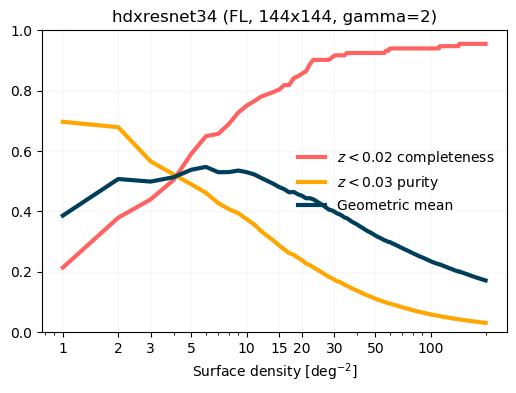

In [44]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    evaluation_metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = evaluation_metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='center right')

plt.title('hdxresnet34 (FL, 144x144, gamma=2)');

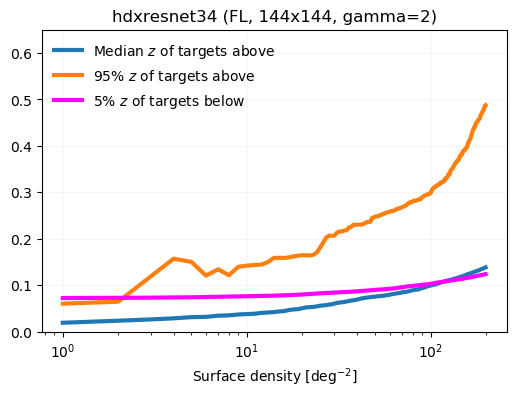

In [45]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet34 (FL, 144x144, gamma=2)');

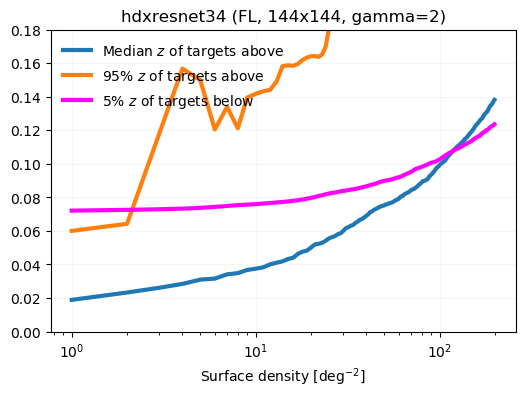

In [47]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.18)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0, loc='upper left')

plt.title('hdxresnet34 (FL, 144x144, gamma=2)');

## Get predictions on DESI SV

In [53]:
desi2 = pd.read_csv(PATH/'results/desi-sv/desi_p2_preds.csv')

In [77]:
for model_name in ['hdxresnet18-sz80', 'hdxresnet18-sz144', 'hdxresnet34-sz144']:
    
    print(f'Working on {model_name}')
    
    # load models and get preds
    desi_sv_preds_all = []
    
    kf = KFold(K)

    for k, [_, val_idx] in enumerate(kf.split(range(N))):
        print(f'  Fold {k+1}/4')
        
        model_path = f'{PATH}/models/desi-sv_FL-{model_name}_{k}'
                    
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader('low_z'),
            splitter=RandomSplitter(0),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )

        dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
        
        if 'hdxresnet34' in model_name:
            model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
        elif 'hdxresnet18' in model_name:
            model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
        else:
            print('No such model...')
            model = None
        
        learn = Learner(
            dls, model, 
            opt_func=ranger, 
            loss_func=loss_func,
            metrics=learner_metrics,
        )
        
        learn.model.load_state_dict(
            torch.load(f'{PATH}/models/desi-sv_FL-{model_name}_{k}')
        )

        # make predictions on images of DESI SV (SAGA-2 cut)
        test_dl = dls.test_dl(
            [f'{PATH}/images-legacy_desi-sv/{objid}.jpg' for objid in desi2.OBJID]
        )
        
        desi_preds, _ = learn.get_preds(dl=test_dl)      
        desi_sv_preds_all.append(desi_preds[:, 1])
        
    # save these predictions
    desi2[f'preds_{model_name}'] = np.mean([t.numpy() for t in desi_sv_preds_all], 0)
    

Working on hdxresnet18-sz144
  Fold 1/4


  Fold 2/4


  Fold 3/4


  Fold 4/4


Working on hdxresnet34-sz144
  Fold 1/4


  Fold 2/4


  Fold 3/4


  Fold 4/4


In [79]:
desi2.to_csv(PATH/'results/desi-sv/desi_p2_ensemble-preds.csv', index=False)

## Predict with freshly trained `hdxresnet34-sz144` model

In [33]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [34]:
sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [35]:
label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

In [36]:

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
)

# learn.fit_one_cycle(10, 1e-2)

# learn.save(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');


/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [51]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
)

learn.load(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');

In [54]:
desi2 = pd.read_csv(PATH/'results/desi-sv/desi_p2_preds.csv')

test_dl = dls.test_dl(
    [f'{PATH}/images-legacy_desi-sv/{objid}.jpg' for objid in desi2.OBJID]
)

desi_preds, _ = learn.get_preds(dl=test_dl)

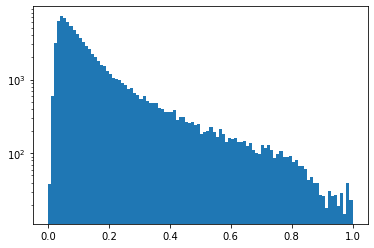

In [55]:
plt.hist(desi_preds[:, 1], bins=100, range=[0,1], log=True);

In [56]:
desi2['preds_hdxresnet34-sz144'] = desi_preds[:, 1]

In [59]:
# desi2.drop(['preds_hdxresnet18-sz80', 'preds_hdxresnet18-sz144'], axis=1).to_csv(PATH/'results/desi-sv/desi_p2_preds.csv', index=False)

In [61]:
desi2 = pd.read_csv(PATH/'results/desi-sv/desi_p2_preds.csv')

desi2.sample(10)

OBJID          RA        DEC      r_mag  p_low_z_6_4  \
4778   903047270000006058   66.681821  -4.385296  21.009954     0.289489   
45445  904771850000004052  168.533656  26.318001  21.998620     0.291520   
46239  904796400000001464  132.562358  26.855979  19.550884     0.409940   
52320  904874400000000502  166.703610  28.356571  19.734974     0.290245   
32913  903939300000004249  134.490070  11.023454  19.563507     0.291631   
63303  905007770000002828   33.640653  30.896488  19.827140     0.522312   
8708   903223440000003585  154.176776  -1.482616  19.213509     0.291789   
11722  903269190000001354  217.804820  -0.783777  21.642483     0.290383   
82082  916058750000000328  108.837066  56.363146  21.802576     0.289479   
36763  904291150000004086  198.485784  17.248307  18.980005     0.374339   

       p_low_z_7_4  preds_hdxresnet34-sz144  
4778      0.286879                 0.044845  
45445     0.287475                 0.157009  
46239     0.638635                 0.399909  
52320     0.287765                 0.065238  
32913     0.290345                 0.124207  
63303     0.295133                 0.299873  
8708      0.290411                 0.043930  
11722     0.287127                 0.054169  
82082     0.290052                 0.065339  
36763     0.580418                 0.296292

In [73]:
desi2_sorted = desi2.sort_values('preds_hdxresnet34-sz144', ascending=False)

In [78]:
desi2_sorted[(desi2_sorted.r_mag > 19) & (desi2_sorted.r_mag < 21)][['RA', 'DEC', 'preds_hdxresnet34-sz144']].iloc[1000:1020]

RA        DEC  preds_hdxresnet34-sz144
64381   23.134540  31.458284                 0.579780
82278  106.213309  56.522930                 0.579524
10553  180.138391  -1.081313                 0.579297
30312  200.681316   7.815965                 0.579180
78247  215.551512  52.043525                 0.579063
21182  150.198605   1.242727                 0.579049
84078  181.584111  57.987254                 0.578726
15391  217.384274  -0.025420                 0.578135
32931  134.672157  11.029578                 0.577979
34862  134.469317  12.499409                 0.577842
52021    3.518663  28.317403                 0.577830
19971  179.283155   1.123450                 0.577786
75206  252.624720  48.595755                 0.577563
54573  356.825422  28.553648                 0.577541
48944  167.909791  27.418589                 0.577334
77678  119.082469  50.653809                 0.577167
42665  157.762716  24.802759                 0.577117
58941   35.971598  29.401502                 0.576892
5577    35.302860  -4.078066                 0.576767
63116   22.692441  30.993008                 0.576695

## Get metrics/zdist


    metrics_dict = {}
    zdist_dict = {}

    res = results[model_name]

    target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
    area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

    for num_density in np.arange(1, 200, 1):
        # metrics
        N = np.round(num_density * area).astype(int)
        mag_range = (19 < res.r_mag) & (res.r_mag < 21)
        subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
        evaluation_metrics = get_top_N_metrics(subset, N)
        metrics_dict[num_density] = evaluation_metrics
        
        N = np.round(num_density * area).astype(int)
    
        # zdist
        subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
        complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]

        zdist = {}

        zdist['p50_z_above'] = np.median(subset.SPEC_Z)
        zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
        zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
        zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)

        zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
        zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
        zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)


        zdist_dict[num_density] = zdist

    # plot metrics
    all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
    metrics_df = all_metrics_df.loc[target_density_values]

    plt.figure(figsize=(6,4), dpi=100)
    plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
    plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
    plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

    plt.ylim(0, 1)
    plt.xscale('log')
    plt.xticks(target_density_values, labels=target_density_values)

    plt.xlabel('Surface density [deg$^{-2}$]')
    plt.grid(alpha=0.1)
    plt.legend(framealpha=0, loc='center right')
    plt.title(model_name);
    plt.show()
    
    # plot zdist
    all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
    zdist_df = all_zdist_df.loc[target_density_values]

    plt.figure(figsize=(6,4), dpi=100)

    plt.plot(all_zdist_df.index, all_zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
    plt.plot(all_zdist_df.index, all_zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
    plt.plot(all_zdist_df.index, all_zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
    plt.grid(alpha=0.2)
    plt.ylim(0, 0.65)
    plt.xscale('log')

    plt.xlabel('Surface density [deg$^{-2}$]')
    plt.grid(alpha=0.1)
    plt.legend(framealpha=0, loc='upper left')

    plt.title(model_name);
    plt.show()

# Separating galaxies from junk using activations

## Hook predictions and conv activations

In [6]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [7]:
sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [8]:
label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

In [9]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
)

learn.load(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');

In [10]:
desi2 = pd.read_csv(PATH/'results/desi-sv/desi_p2_preds.csv')

test_dl = dls.test_dl(
    [f'{PATH}/images-legacy_desi-sv/{objid}.jpg' for objid in desi2.OBJID],
    num_workers=4
)

In [11]:
(xb,) = next(iter(test_dl))

xb.shape

torch.Size([128, 3, 144, 144])

In [18]:
m = learn.model.eval()

with hook_output(learn.model[-4]) as hook:
    outputs = []
    activs = []
    with torch.no_grad():
        for (xb,) in tqdm.tqdm(iter(test_dl), total=len(test_dl)):
            outputs.append(m(xb).cpu())     # must send to CPU, otherwise sklearn will be mad
            activs.append(hook.stored.cpu())

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa59090e710>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/envs/fastai2/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa59090e710>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/envs/fastai2/lib/python3.7/multiprocessing/process.py"

In [19]:
outs = torch.cat(outputs)
acts = torch.cat(activs)

outs.shape, acts.shape

(torch.Size([88428, 2]), torch.Size([88428, 512, 1, 1]))

In [20]:
outs = outs.softmax(1)
acts = acts.reshape(acts.shape[0], -1)

outs.shape, acts.shape

(torch.Size([88428, 2]), torch.Size([88428, 512]))

## Dimensionality reduction

In [17]:
pca = PCA()

In [18]:
acts_pca = pca.fit_transform(
    acts.reshape((acts.shape[0], -1))
)

In [19]:
acts_pca.shape

(88428, 512)

In [38]:
df = pd.DataFrame(
    acts_pca[:, :6],
    columns=[f'PCA_{i}' for i in range(6)],
    index=desi2.OBJID
)

df['RA'] = desi2.RA.values
df['DEC'] = desi2.DEC.values
df['p_CNN'] = desi2['preds_hdxresnet34-sz144'].values

df.sample(5)

PCA_0     PCA_1     PCA_2     PCA_3     PCA_4  \
OBJID                                                                  
904822110000000392 -0.465406 -0.000246 -0.151226  0.274453  0.011053   
904731640000004959 -0.935165  0.358494  0.767029 -0.020560  0.363679   
903297950000000740 -0.547521 -0.024048  0.064386  0.235946 -0.078818   
904791820000003364  0.839218 -0.320721 -0.009116  0.041344  0.006499   
904956690000004275  0.543526 -0.229050 -0.329368 -0.060196 -0.058055   

                       PCA_5     p_CNN  
OBJID                                   
904822110000000392 -0.015269  0.054880  
904731640000004959  0.362718  0.019791  
903297950000000740 -0.081196  0.049408  
904791820000003364  0.196334  0.309485  
904956690000004275 -0.012420  0.265273

Categorize by p_CNN

In [39]:
df['probability'] = pd.cut(df.p_CNN, bins=[0, 0.1, 0.5, 1], labels=['low', 'medium', 'high'])
df.sample(5)

PCA_0     PCA_1     PCA_2     PCA_3     PCA_4  \
OBJID                                                                  
904875440000000327  1.648271  0.191874 -0.197201 -0.133509  0.161475   
903004220000002734 -0.593312  0.238843  0.425170 -0.273671  0.049793   
904894040000001907 -0.072990 -0.184595 -0.175399  0.033649 -0.074130   
904970580000001545  0.693282  0.712672 -0.205049  0.245915  0.527860   
903002990000002888 -1.306279  0.425057  0.825789  0.333987  0.149153   

                       PCA_5     p_CNN probability  
OBJID                                               
904875440000000327 -0.111596  0.705550        high  
903004220000002734 -0.018916  0.050435         low  
904894040000001907 -0.000918  0.110316      medium  
904970580000001545 -0.227349  0.312720      medium  
903002990000002888  0.092524  0.009568         low

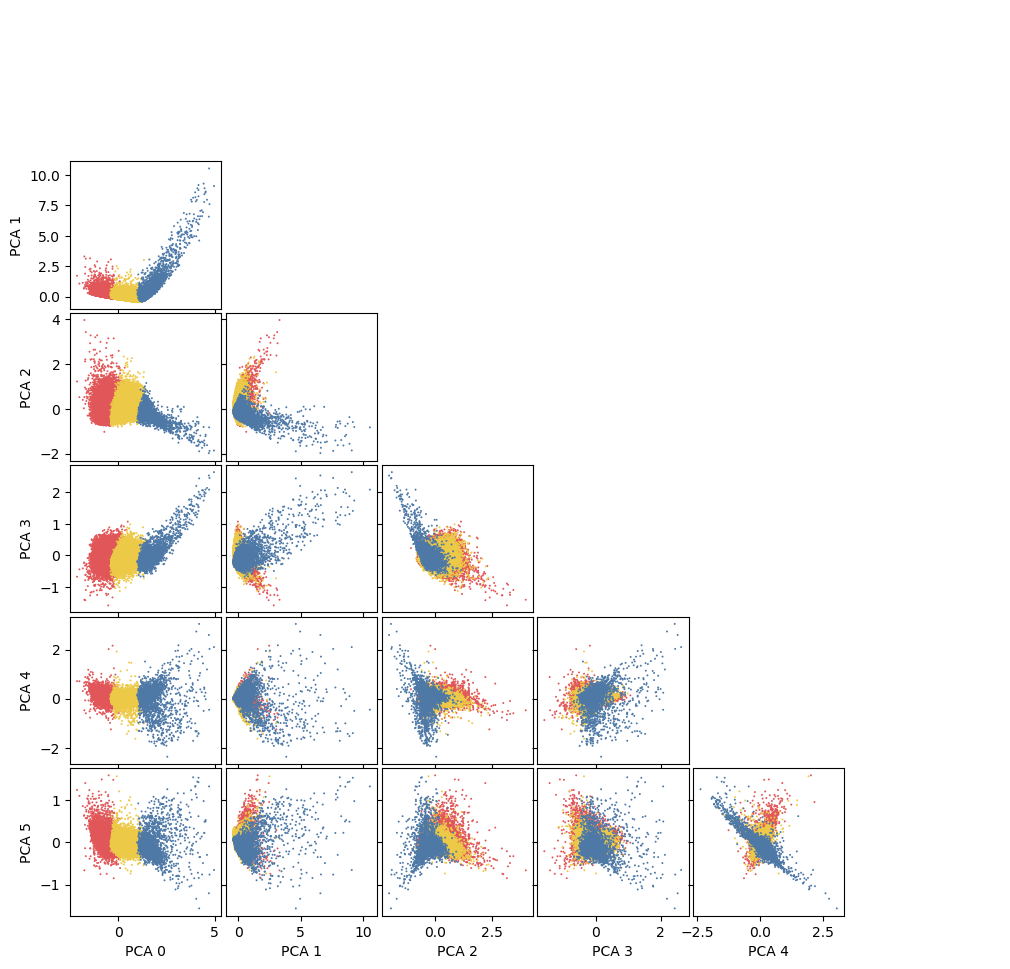

In [59]:
# visualize first few components
fig, axes = plt.subplots(6, 6, figsize=(12, 12), dpi=100)


for i in range(6):
    for j in range(6):
        ax = axes[i ,j]

        for color, prob in zip(['#e15759', '#edc948', '#4e79a7'], ['low', 'medium', 'high']):
            if i <= j: 
                ax.axis('off')
            else: 
                ax.scatter(
                    df[df.probability == prob][f'PCA_{j}'], 
                    df[df.probability == prob][f'PCA_{i}'], 
                    c=color, s=2, edgecolor='none'
                )
        
        if i == 5: 
            ax.set_xlabel(f'PCA {j}')
        else:
            ax.set_xticklabels([])
        if j == 0: 
            ax.set_ylabel(f'PCA {i}')
        else:
            ax.set_yticklabels([])
            
    ax.set_xlim(*np.quantile(df[f'PCA_{j}'], [0.02, 0.98]))
    ax.set_ylim(*np.quantile(df[f'PCA_{i}'], [0.02, 0.98]))


fig.subplots_adjust(wspace=0.03, hspace=0.03)

In [66]:
selection = (df.PCA_1 > 5) & (df.probability == 'high')
df[['RA', 'DEC', 'p_CNN']][selection].sample(20)               # mostly shreds

RA        DEC     p_CNN
OBJID                                              
916130510000001584  178.744808  58.493603  0.996277
915869670000003479  120.470892  50.737167  0.997494
903253280000002045  180.084556  -1.114983  0.948095
903253280000001953  180.080797  -1.108228  0.965708
915869670000003670  120.485259  50.734429  0.992377
903253280000002316  180.095115  -1.089517  0.953950
902988600000008158   35.387071  -5.517033  0.978329
902988600000008424   35.395326  -5.532006  0.976208
915869670000003352  120.461240  50.744763  0.968663
902988610000000413   35.407366  -5.534572  0.981600
915219460000000386  217.606064  35.321142  0.992740
903253280000002756  180.111433  -1.099522  0.987353
903253280000002281  180.093326  -1.096326  0.987295
916130510000001691  178.755925  58.487442  0.984135
903253280000002689  180.108686  -1.113596  0.984053
903253280000002606  180.105625  -1.116143  0.984371
915869670000003696  120.487691  50.734828  0.986032
903253280000002457  180.100270  -1.110710  0.995175
902988600000008207   35.388765  -5.520200  0.978469
915869670000003695  120.487568  50.736671  0.986164

In [70]:
selection = (df.PCA_3 > 1.) & (df.probability == 'high')
df[['RA', 'DEC', 'p_CNN']][selection].sample(20)             # also mostly shreds

RA        DEC     p_CNN
OBJID                                              
902988600000008324   35.392401  -5.519337  0.993404
903253280000002687  180.108623  -1.083404  0.972349
902988610000000791   35.416942  -5.527746  0.983031
916130510000001584  178.744808  58.493603  0.996277
903253280000002333  180.095624  -1.092443  0.986542
903253280000002598  180.105295  -1.101539  0.993986
902988600000008385   35.394104  -5.510075  0.968213
915869670000003696  120.487691  50.734828  0.986032
903238890000001013  180.301882  -1.293580  0.957246
902988610000000581   35.411845  -5.526714  0.991369
902988610000000181   35.400366  -5.506837  0.949746
916130510000001560  178.741997  58.505113  0.987470
903238890000001007  180.301571  -1.296274  0.966430
915823260000002912  119.257630  49.567379  0.970443
916130510000001601  178.746877  58.485326  0.975611
902988610000000203   35.400975  -5.524542  0.995427
915869670000003594  120.479338  50.748815  0.949598
915869670000003446  120.468632  50.728234  0.986469
903238890000000987  180.300826  -1.291677  0.953135
903253280000002447  180.099922  -1.118124  0.989535

In [71]:
selection = (df.PCA_3 < 1.) & (df.probability == 'high')
df[['RA', 'DEC', 'p_CNN']][selection].sample(20)                 # mostly centrals, some smaller shreds

RA        DEC     p_CNN
OBJID                                              
904862700000004484  195.818938  27.947754  0.502499
904913330000000808  193.730887  29.012353  0.599673
916107630000002808  180.786764  57.668476  0.628216
904888090000002259  195.169360  28.519598  0.655237
903742850000000503  202.681248   7.530202  0.641434
903468130000004786  151.495611   2.850975  0.556837
904849900000003282  194.313815  27.729807  0.766559
904881340000003946    3.642432  28.450507  0.799793
903413160000000699  217.035926   1.823798  0.768299
904849950000000140  195.525010  27.765129  0.545636
904881100000002803  356.813453  28.349232  0.572127
904900720000000703  194.280439  28.693835  0.729993
915769620000002776  252.127087  47.917434  0.512514
903369940000005789  216.721042   0.962862  0.790370
904849920000004841  194.947686  27.706197  0.820376
904888060000005454  194.474758  28.499823  0.650582
903237860000000766  154.541643  -1.241837  0.775922
904771830000001929  167.882366  26.296035  0.594360
903355570000003967  217.419233   0.833058  0.805637
903384350000002796  216.863146   1.336697  0.659638

In [73]:
# df.to_csv(PATH/'results/desi-sv/desi2-pca-results.csv', index=True)

## t-SNE

In [24]:
tsne = TSNE(n_components=2)

In [25]:
acts_tsne = tsne.fit_transform(
    acts.reshape((acts.shape[0], -1))
)

In [26]:
acts_tsne.shape

(88428, 2)

In [27]:
df = pd.read_csv(PATH/'results/desi-sv/desi2-pca-results.csv')
df['TSNE_0'] = acts_tsne[:, 0]
df['TSNE_1'] = acts_tsne[:, 1]

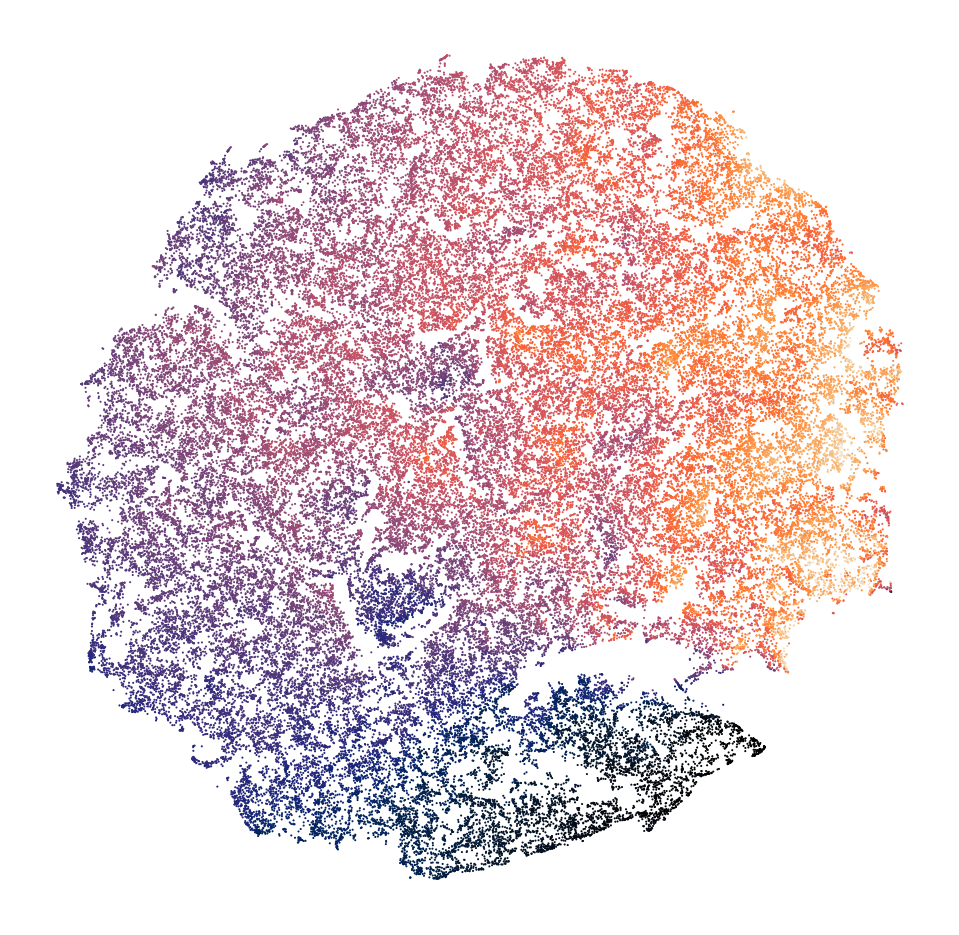

In [47]:
plt.figure(figsize=(8, 8), dpi=150)

plt.scatter(
    df.TSNE_0,
    df.TSNE_1,
    c=df.p_CNN.apply(np.log10),
    s=1, 
    edgecolor='none',
    cmap='cmr.heat_r',
    vmin=-2,
    vmax=0
)
plt.axis('off')


plt.savefig(PATH/'results/desi-sv/desi2_tsne_visualization.pdf')

In [46]:
# df.to_csv(PATH/'results/desi-sv/desi2-tsne-results.csv', index=False)

## UMAP

### 6 components, 5 NNs

In [49]:
from umap import UMAP

umap = UMAP(n_neighbors=5, n_components=6)

In [50]:
acts_umap = umap.fit_transform(acts)

In [51]:
acts_umap.shape

(88428, 6)

In [52]:
df = pd.DataFrame(
    acts_umap,
    columns=[f'UMAP_{i}' for i in range(6)],
    index=desi2.OBJID
)

df['RA'] = desi2.RA.values
df['DEC'] = desi2.DEC.values
df['p_CNN'] = desi2['preds_hdxresnet34-sz144'].values

df['TSNE_0'] = acts_tsne[:, 0]
df['TSNE_1'] = acts_tsne[:, 1]

df.sample(5)

UMAP_0    UMAP_1    UMAP_2    UMAP_3    UMAP_4  \
OBJID                                                                  
903785660000001469  4.859725 -0.422636  3.775720  6.591727  6.339606   
903282080000004925 -2.244100  1.286346  8.414033  5.532756  5.914884   
903017340000008441  6.140380 -0.490564  4.941158  5.219991  6.273944   
915759930000002411  2.496154  0.271825  5.655448  6.971572  7.009312   
915969620000000494 -0.837194  0.839944  6.368601  7.218650  3.368150   

                      UMAP_5          RA        DEC     p_CNN     TSNE_0  \
OBJID                                                                      
903785660000001469  6.972828  202.030580   8.322560  0.148932 -20.655354   
903282080000004925  5.521961  180.189804  -0.468580  0.052498  24.716999   
903017340000008441  7.129006   36.336766  -5.026903  0.221371 -20.014336   
915759930000002411  5.664534  251.645964  47.709754  0.121187   5.720892   
915969620000000494  4.695027  213.535517  53.550459  0.077279  -3.484940   

                       TSNE_1  
OBJID                          
903785660000001469 -13.894878  
903282080000004925   6.389140  
903017340000008441 -23.184019  
915759930000002411 -13.516353  
915969620000000494  21.096867

In [53]:
# df.to_csv(PATH/'results/desi-sv/desi2-umap-results.csv', index=True)

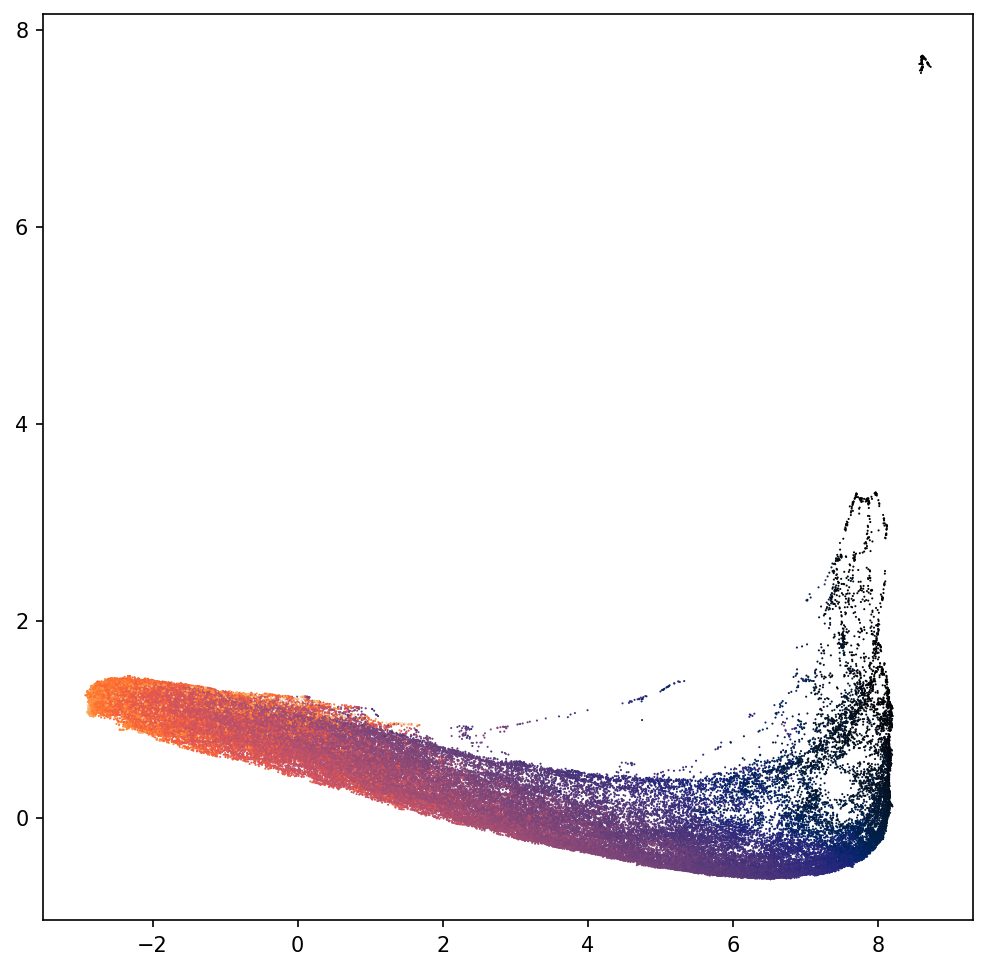

In [55]:
plt.figure(figsize=(8, 8), dpi=150)

plt.scatter(
    df.UMAP_0,
    df.UMAP_1,
    c=df.p_CNN.apply(np.log10),
    s=1, 
    edgecolor='none',
    cmap='cmr.heat_r',
    vmin=-2,
    vmax=0
)


What are those guys in the upper right corner?

In [57]:
df[df.UMAP_1 > 6].sample(20)[['RA', 'DEC']]

RA        DEC
OBJID                                    
915219460000000386  217.606064  35.321142
904913320000004788  193.662773  28.931006
903253280000002046  180.084575  -1.116007
903253280000002598  180.105295  -1.101539
915869670000003567  120.477221  50.732623
902988610000000231   35.401700  -5.534771
915869670000003670  120.485259  50.734429
902988610000000241   35.401939  -5.521127
916130510000001584  178.744808  58.493603
903253280000001957  180.080935  -1.100648
903253280000002265  180.092817  -1.083078
903253280000001953  180.080797  -1.108228
902988610000000413   35.407366  -5.534572
903253280000002042  180.084485  -1.093164
916130510000001406  178.727543  58.497337
902988610000000581   35.411845  -5.526714
916130510000001601  178.746877  58.485326
904913320000004842  193.665655  28.939275
903253280000002276  180.093145  -1.100663
903253280000002267  180.092826  -1.087979

Answer: bright stuff and shreds.

What about stuff that's not as far away but still has a high prediction?

In [58]:
df[(df.UMAP_1 < 4) & (df.p_CNN > 0.5)].sample(20)[['RA', 'DEC']]

RA        DEC
OBJID                                    
903312350000005799  216.987251   0.022746
903210070000001950  179.848162  -1.654532
915869670000003097  120.445325  50.726704
903410460000002440  149.622819   1.692718
904693340000002059  157.868074  24.848987
903282080000005054  180.194425  -0.481460
916017810000003509  106.600729  54.884270
904277380000001957  198.644812  16.889030
915422330000001334  114.585029  39.728954
904546160000001851  116.307526  22.010278
903031690000005531   36.003902  -4.693075
904913380000000270  195.130309  28.950469
904944180000001238  356.638964  29.400636
905044410000004544   23.374932  31.804436
904982960000003072   34.299308  30.598318
916003620000001210  214.411159  54.593049
904899790000001052  167.809669  28.713145
904817580000000945    5.105957  27.142569
904837160000001987  195.301259  27.604479
915740410000000964  250.971548  47.183662

Definitely fewer major shreds!

In [59]:
df[(df.UMAP_1 < 2) & (df.p_CNN > 0.5)].sample(20)[['RA', 'DEC']]

RA        DEC
OBJID                                    
904887110000004231  167.432662  28.553918
904830400000000849    5.104904  27.487835
904849020000001163  169.341276  27.673301
903871080000004003  202.493394   9.662579
904849940000004554  195.500584  27.782723
904862690000002482  195.390996  27.911143
903004250000005589   68.146342  -5.366470
904906730000003850    5.633511  28.892531
915085610000001576  155.890413  32.599676
904894030000003547    3.888738  28.652809
904849910000002066  194.507168  27.853563
904919330000003381    5.069535  29.184355
904913340000005386  194.249553  29.068459
904849960000004048  196.019819  27.850501
915969680000001204  216.132492  53.622759
904849920000002482  194.806257  27.774615
904888060000000779  194.235744  28.623368
903326780000004351  217.695999   0.213438
903004210000003242   67.080891  -5.179530
904837150000005248  195.183256  27.593661

(2.4771585220418952, 11.190253282157324, 3.9035839054495036, 9.078987696418173)

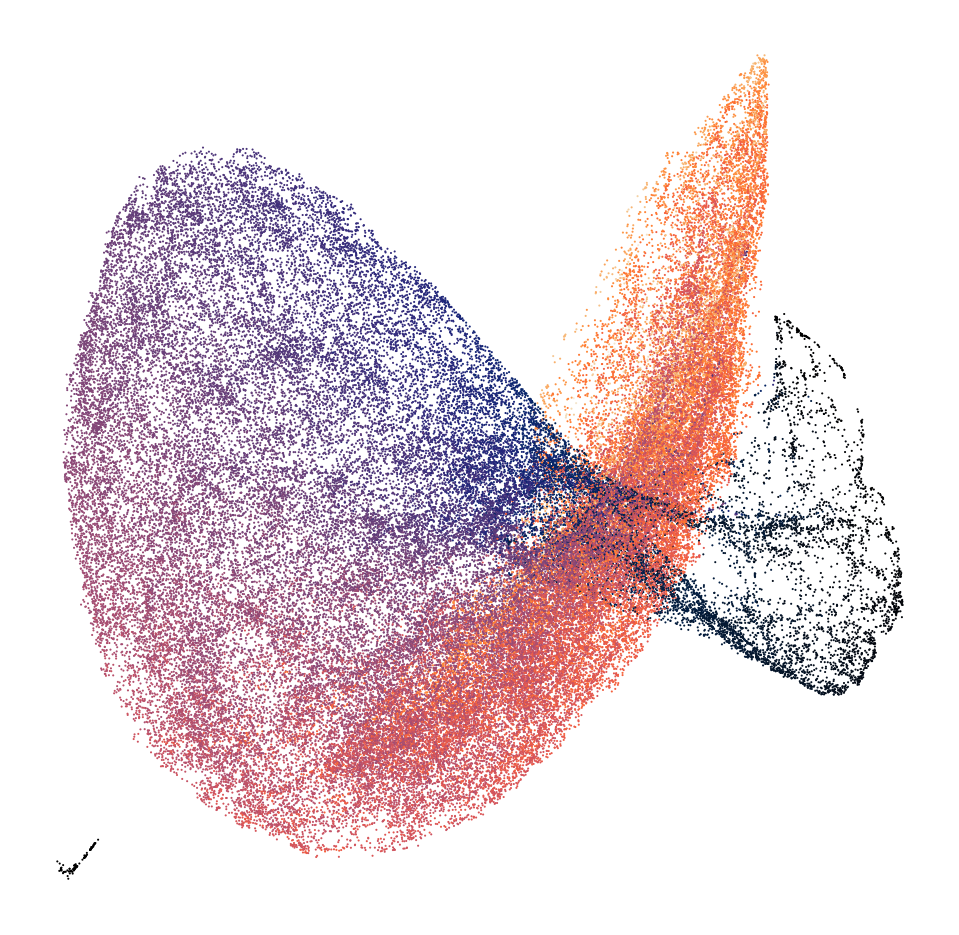

In [70]:
plt.figure(figsize=(8, 8), dpi=150)

plt.scatter(
    df.UMAP_2,
    df.UMAP_5,
    c=df.p_CNN.apply(np.log10),
    s=1, 
    edgecolor='none',
    cmap='cmr.heat_r',
    vmin=-2,
    vmax=0
)

plt.axis('off')

UMAP -> PCA (2 components)

In [71]:
acts_umap2 = PCA(n_components=2).fit_transform(acts_umap)

(-5.78437876757755, 6.795194864837073, -4.458345916518576, 4.517409351119406)

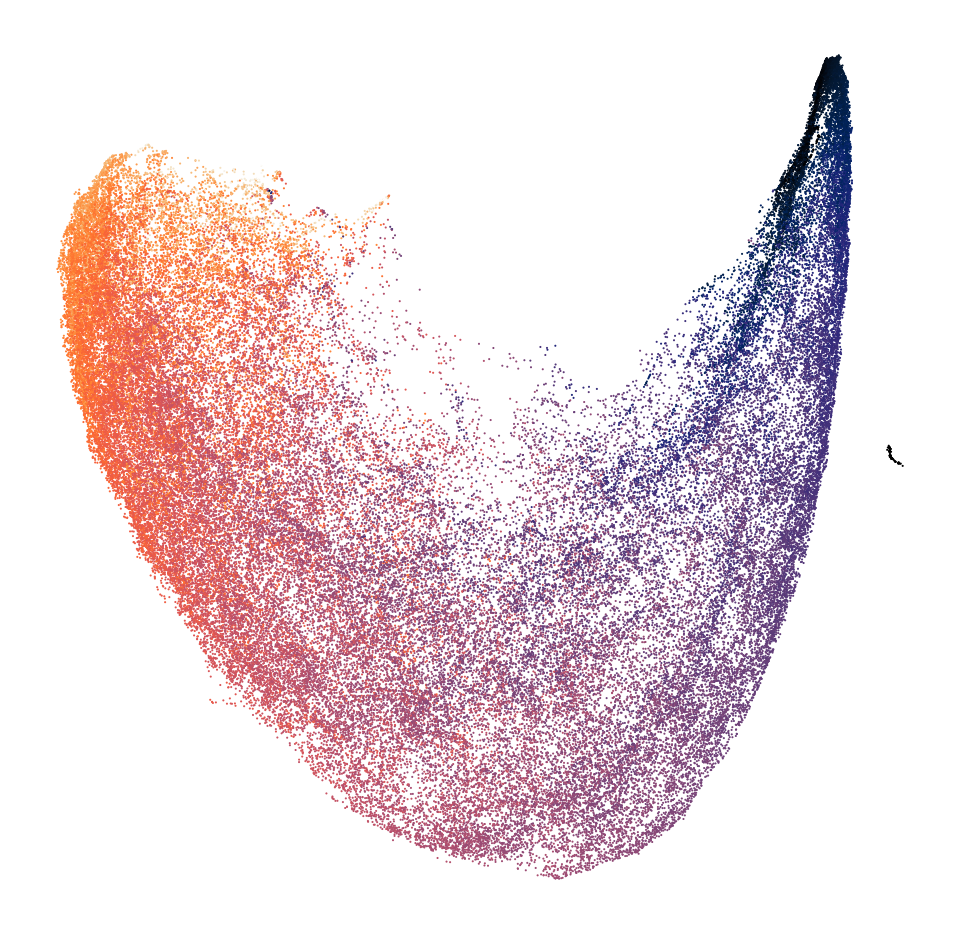

In [72]:
plt.figure(figsize=(8, 8), dpi=150)

plt.scatter(
    acts_umap2[:, 0],
    acts_umap2[:, 1],
    c=df.p_CNN.apply(np.log10),
    s=1, 
    edgecolor='none',
    cmap='cmr.heat_r',
    vmin=-2,
    vmax=0
)

plt.axis('off');

### 2 components, 30 NNs

In [91]:
acts_umap = UMAP(n_neighbors=30, n_components=2, min_dist=0.05).fit_transform(acts)

In [92]:
df = pd.DataFrame(
    acts_umap,
    columns=['UMAP_0', 'UMAP_1'],
    index=desi2.OBJID
)

df['RA'] = desi2.RA.values
df['DEC'] = desi2.DEC.values
df['p_CNN'] = desi2['preds_hdxresnet34-sz144'].values

df['TSNE_0'] = acts_tsne[:, 0]
df['TSNE_1'] = acts_tsne[:, 1]

df.sample(5)

UMAP_0    UMAP_1          RA        DEC     p_CNN  \
OBJID                                                                     
902988610000001272  9.869882  4.141651   35.429501  -5.529199  0.700639   
903253260000000601  0.335286  3.139089  179.529044  -1.017566  0.041436   
916034320000000943 -0.484964 -2.489038  106.319439  55.486502  0.198441   
903714330000001803 -0.196171  0.326482  204.738873   7.011473  0.058506   
915207590000000631  6.231756 -0.877493  215.369690  35.070413  0.167774   

                       TSNE_0     TSNE_1  
OBJID                                     
902988610000001272  22.680393 -33.012310  
903253260000000601  21.788124  -4.672747  
916034320000000943 -28.143723  27.410484  
903714330000001803  -2.322182  15.980862  
915207590000000631 -17.580786 -17.425562

In [ ]:
plt.figure(figsize=(8, 8), dpi=150)

plt.scatter(
    df.UMAP_0,
    df.UMAP_1,
    c=df.p_CNN.apply(np.log10),
    s=1, 
    edgecolor='none',
    cmap='cmr.heat_r',
    vmin=-2,
    vmax=0
)

plt.axis('off')

(-6.311853290168187, 12.434462428656957, -4.407338252314932, 6.170531144389517)